In [13]:
# import libraries

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns

In [29]:
# load dataset
spotify = pd.read_csv('spotify_2023.csv', encoding='latin1')

# Peeking at dataset & variables
print("Shape (rows, columns):\n", spotify.shape)
print("\nData Types:\n", spotify.dtypes)
print("\nHead:\n", spotify.head())
print("\nSummary Statistics:\n", spotify.describe())
print("\nMissing Values:\n", spotify.isnull().sum())



Shape (rows, columns):
 (953, 24)

Data Types:
 track_name              object
artist(s)_name          object
artist_count             int64
released_year            int64
released_month           int64
released_day             int64
in_spotify_playlists     int64
in_spotify_charts        int64
streams                 object
in_apple_playlists       int64
in_apple_charts          int64
in_deezer_playlists     object
in_deezer_charts         int64
in_shazam_charts        object
bpm                      int64
key                     object
mode                    object
danceability_%           int64
valence_%                int64
energy_%                 int64
acousticness_%           int64
instrumentalness_%       int64
liveness_%               int64
speechiness_%            int64
dtype: object

Head:
                             track_name    artist(s)_name  artist_count  \
0  Seven (feat. Latto) (Explicit Ver.)  Latto, Jung Kook             2   
1                                 LALA

In [ ]:
# Data Cleaning

# converting object data types to numeric, and dropping missing values
spotify['streams'] = pd.to_numeric(spotify['streams'], errors='coerce')
spotify['in_deezer_playlists'] = pd.to_numeric(spotify['in_deezer_playlists'], errors='coerce')
spotify['in_shazam_charts'] = pd.to_numeric(spotify['in_shazam_charts'], errors='coerce')

# fill missing values
spotify['key'] = spotify['key'].fillna('n/a')
spotify['in_shazam_charts'] = spotify['in_shazam_charts'].fillna('0')

spotify.dtypes

track_name               object
artist(s)_name           object
artist_count              int64
released_year             int64
released_month            int64
released_day              int64
in_spotify_playlists      int64
in_spotify_charts         int64
streams                 float64
in_apple_playlists        int64
in_apple_charts           int64
in_deezer_playlists     float64
in_deezer_charts          int64
in_shazam_charts        float64
bpm                       int64
danceability_%            int64
valence_%                 int64
energy_%                  int64
acousticness_%            int64
instrumentalness_%        int64
liveness_%                int64
speechiness_%             int64
key_A#                     bool
key_B                      bool
key_C#                     bool
key_D                      bool
key_D#                     bool
key_E                      bool
key_F                      bool
key_F#                     bool
key_G                      bool
key_G#  

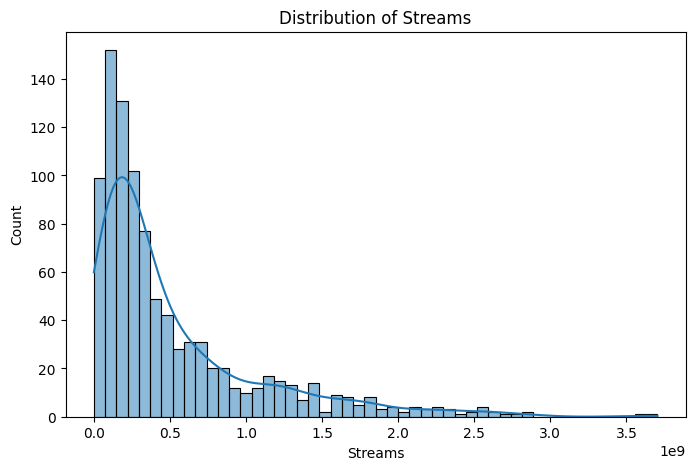

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(spotify["streams"].dropna(), bins=50, kde=True)
plt.title("Distribution of Streams")
plt.xlabel("Streams")
plt.ylabel("Count")
plt.show()